In [28]:
import sys, os
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#DWave Credentials
dwave_solver = 'DW_2000Q_2_1'
api_key = 'DEV-ea3f2e364bc24729fc317e26d4d167016c5b08bf'

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [30]:
def MakeGraph(corr_mat, node_labels, type):

    G=nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not= corr matrix dimensions')

    if type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if not corr_mat[i,j] == 0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0:
                    G.add_edge(node_labels[i], node_labels[j])
                
    return G        

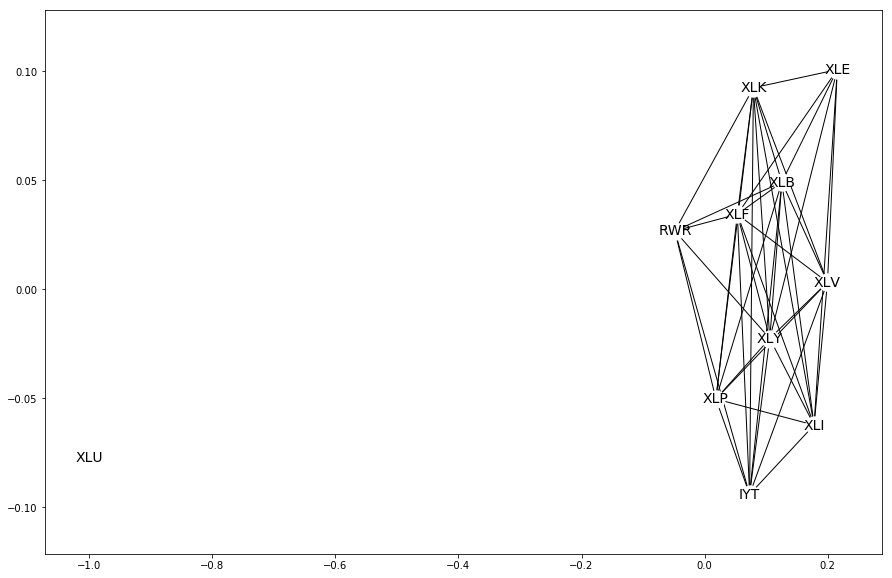

In [51]:
# node_labels = ['STCK','MCAP','SCAP','TRES3','BOND','TRES20','BOND2','BDMUN','WRLD','WRLD2','EMKT','REAL','COM','GOLD']
# corr_mat_df = pd.read_csv('AssetClasses.csv', header=None, names=node_labels)
# corr_mat = corr_mat_df.values

# node_labels = ['EUR','AUD','BRL','CAD','CNY','DKK','HKD','INR','JPY','KRW','MYR','MXN','NZD','NOK','SGD','ZAR','LKR','SEK','CHF','TWD','TBT','GBP','VEF']
# corr_mats = sio.loadmat('S_mat_forex.mat').get('S_mat')
# corr_mat=corr_mats[3000,:,:]
# #corr_mat_df = pd.DataFrame(corr_mat, header=None, names=node_labels)

dataset='sectors'
corr_mats = np.load(dataset+'_corr.npy')
dates = np.load(dataset+'_dates.npy')
nodes = np.load(dataset+'_nodes.npy')
nodes_descr = np.load(dataset+'_nodes_descr.npy')

# just pick a single corr matrix
corr_mat=corr_mats[115,:,:]

# threshold corr matrix
thresh = .3
corr_mat[(corr_mat>-thresh)&(corr_mat<thresh)]=0

# create graph
G_type='corr'
G=MakeGraph(corr_mat,nodes,type=G_type)

# run quantum algo
#imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
max_clique = dnx.maximum_clique(G,sampler)
max_indep = dnx.maximum_independent_set(G,sampler)
coloring= dnx.min_vertex_coloring(G, sampler)

# draw graph    
fig, ax = plt.subplots(figsize=(15, 10))
nx.draw_networkx(G,pos=nx.spring_layout(G), font_size=14, node_color='w', ax=ax)


In [50]:
print(coloring)
print(max_clique)
print(max_indep)


{'IYT': 0, 'RWR': 1, 'XLB': 2, 'XLE': 3, 'XLF': 4, 'XLI': 5, 'XLK': 6, 'XLP': 7, 'XLV': 8, 'XLY': 9, 'XLU': 6}
['IYT', 'RWR', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLV', 'XLY']
['IYT', 'XLU']


In [52]:
print(coloring)
print(max_clique)
print(max_indep)

{'IYT': 0, 'RWR': 1, 'XLB': 2, 'XLF': 3, 'XLK': 4, 'XLP': 5, 'XLY': 6, 'XLE': 5, 'XLI': 7, 'XLV': 1, 'XLU': 0}
['IYT', 'XLB', 'XLF', 'XLI', 'XLK', 'XLP', 'XLV', 'XLY']
['IYT', 'XLE', 'XLU']
